In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# importing the 'Value' type
from utils import Value, MLP
from utils import PalindromeDataset, PalindromeDatasetFull

In [3]:
# Example computation
a = Value(1)
b = Value(2)
c = Value(3)
d = Value(4)

e = a*b + c*d
f = e/2.

# checking final values and initial grads (should be zero)
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

# backprop
f.backward()

# checking final grads
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

Value(data=14) Value(data=7.0) 0 0 0 0 0 0
Value(data=14) Value(data=7.0) 1.0 0.5 2.0 1.5 0.5 1


In [4]:
# showing the training of a simple NN, with some data
# input dim=3, output dim=1, atchitecture : NN with 4 layers : 3,4,4,1 neurons resp
from utils import MLP

# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1] # labels
losslog = []
a = MLP(3, [4,4,1])
for step in range(200) : # 200 epochs
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

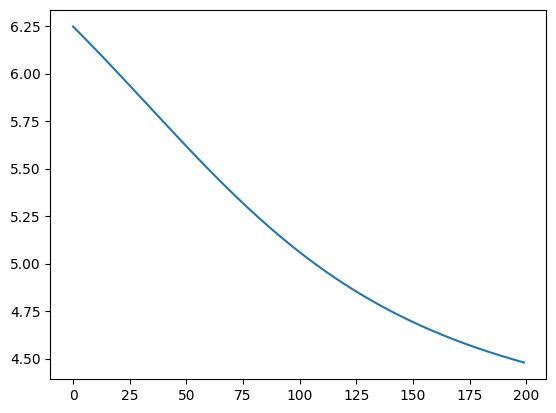

In [5]:
plt.plot(losslog)
plt.show()

In [6]:
# checking performance on the four data points
# should be close to ys=[1,-1,-1,1]
[a(x)[0] for x in xs]

[Value(data=0.3416816409636154),
 Value(data=0.3401759402280529),
 Value(data=0.3496198213170757),
 Value(data=0.34816719709276533)]

In [7]:
datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(512, 512)

In [8]:
len(dataset)

1024

In [9]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

In [10]:
# showing the training of a simple NN, with some data
# input dim=10, output dim=1, architecture : NN with 1 hidden layers : 4 with neurons
from utils import MLP
from tqdm.auto import tqdm

losslog = []
a = MLP(10, [4, 1])
weight = 1. # added weight to try and counter the class imbalance
nepochs = 751

xs, ys = convert_to_form(dataset)

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()

    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

  0%|          | 1/751 [00:00<07:25,  1.68it/s]

epoch 0 loss 763.8345


  7%|▋         | 51/751 [00:48<11:58,  1.03s/it]

epoch 50 loss 678.6858


 13%|█▎        | 101/751 [01:43<11:51,  1.09s/it]

epoch 100 loss 538.0748


 20%|██        | 151/751 [02:37<12:52,  1.29s/it]

epoch 150 loss 463.4653


 27%|██▋       | 201/751 [03:33<07:47,  1.18it/s]

epoch 200 loss 335.5569


 33%|███▎      | 251/751 [04:28<09:48,  1.18s/it]

epoch 250 loss 214.2018


 40%|████      | 301/751 [05:30<11:11,  1.49s/it]

epoch 300 loss 110.0578


 47%|████▋     | 351/751 [06:24<06:43,  1.01s/it]

epoch 350 loss 64.3994


 53%|█████▎    | 401/751 [07:13<07:14,  1.24s/it]

epoch 400 loss 48.7734


 60%|██████    | 451/751 [08:21<05:47,  1.16s/it]

epoch 450 loss 38.8136


 67%|██████▋   | 501/751 [09:15<03:50,  1.08it/s]

epoch 500 loss 31.8381


 73%|███████▎  | 551/751 [10:06<03:19,  1.00it/s]

epoch 550 loss 26.6831


 80%|████████  | 601/751 [10:59<02:48,  1.13s/it]

epoch 600 loss 22.7579


 87%|████████▋ | 651/751 [11:55<01:35,  1.05it/s]

epoch 650 loss 19.7070


 93%|█████████▎| 701/751 [12:51<01:06,  1.32s/it]

epoch 700 loss 17.2918


100%|██████████| 751/751 [13:43<00:00,  1.10s/it]

epoch 750 loss 15.3462


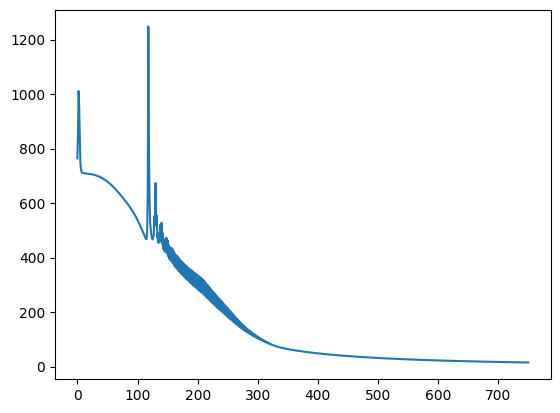

In [11]:
plt.plot(losslog)
plt.show()

In [12]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.9883 f1 0.9884
Threshold 0.2 accuracy 0.9922 f1 0.9922
Threshold 0.3 accuracy 0.9961 f1 0.9961
Threshold 0.4 accuracy 0.9990 f1 0.9990
Threshold 0.5 accuracy 0.9990 f1 0.9990
Threshold 0.6 accuracy 1.0000 f1 1.0000
Threshold 0.7 accuracy 1.0000 f1 1.0000
Threshold 0.8 accuracy 1.0000 f1 1.0000
Threshold 0.9 accuracy 1.0000 f1 1.0000


In [13]:
max(predictions), min(predictions)

(0.9903868410118197, 2.2446800530510573e-08)

In [14]:
#from sklearn.metrics import confusion_matrix

# testing on full dataset
test_datasetMaker = PalindromeDatasetFull(10)
test_dataset = test_datasetMaker.generate_dataset()

xs, ys = convert_to_form(test_dataset)

predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    preds = 1*(predictions > i/10)

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)

    print(i/10, acc, f1)

#confusion_matrix(ys, preds)

0.1 0.935546875 0.49230768852071016
0.2 0.953125 0.571428567244898
0.3 0.96484375 0.6399999955200001
0.4 0.974609375 0.7111111063703703
0.5 0.982421875 0.7804877999286138
0.6 0.986328125 0.8205128154635108
0.7 0.9873046875 0.831168826095463
0.8 0.98828125 0.8421052580609418
0.9 0.9892578125 0.8533333282133334


In [17]:
preds = 1*(predictions > 0.98)

true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

num_correct = true_neg + true_pos
prec = true_pos / (true_pos + false_pos + eps)
recall = true_pos / (true_pos + false_neg + eps)
f1 = 2*prec*recall / (prec + recall + eps)
acc = num_correct / len(ys)

print(0.98, acc, f1)

#confusion_matrix(ys, preds)

0.98 0.9970703125 0.950819666831497


In [32]:
print(true_pos)
print(true_neg)
print(false_pos)
print(false_neg)

29
992
0
3


In [16]:
#print(a)
#print(dir(MLP))
print(a.hidden_layer_act(xs[0]))


[Value(data=0.07127847883376737), Value(data=0.0015606607296031526), Value(data=0.8142661883079557), Value(data=0.0615899247358753)]


In [25]:
preds = 1*(predictions > 0.98)

true_pos_x = []
true_neg_x = []
false_pos_x = []
false_neg_x = []

for i in range(len(preds)):
    if(preds[i]==1 and ys[i]==1):
        true_pos_x.append(xs[i])
    if(preds[i]==0 and ys[i]==0):
        true_neg_x.append(xs[i])
    if(preds[i]==1 and ys[i]==0):
        false_pos_x.append(xs[i])
    if(preds[i]==0 and ys[i]==1):
        false_neg_x.append(xs[i])



In [26]:
true_pos_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in true_pos_x])
true_pos_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in true_pos_x])
true_pos_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in true_pos_x])
true_pos_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in true_pos_x])

false_pos_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in false_pos_x])
false_pos_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in false_pos_x])
false_pos_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in false_pos_x])
false_pos_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in false_pos_x])

true_neg_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in true_neg_x])
true_neg_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in true_neg_x])
true_neg_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in true_neg_x])
true_neg_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in true_neg_x])

false_neg_act_1 = np.array([a.hidden_layer_act(k)[0].data for k in false_neg_x])
false_neg_act_2 = np.array([a.hidden_layer_act(k)[1].data for k in false_neg_x])
false_neg_act_3 = np.array([a.hidden_layer_act(k)[2].data for k in false_neg_x])
false_neg_act_4 = np.array([a.hidden_layer_act(k)[3].data for k in false_neg_x])

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


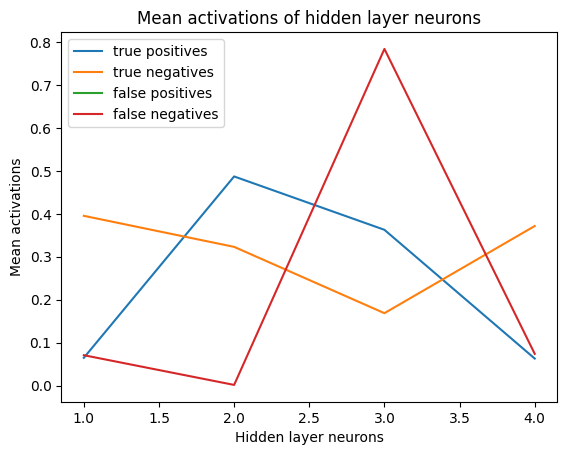

In [39]:
tpa1_mean=np.mean(true_pos_act_1)
tpa2_mean=np.mean(true_pos_act_2)
tpa3_mean=np.mean(true_pos_act_3)
tpa4_mean=np.mean(true_pos_act_4)
tpmeanarr=np.array([tpa1_mean,tpa2_mean,tpa3_mean,tpa4_mean])

tna1_mean=np.mean(true_neg_act_1)
tna2_mean=np.mean(true_neg_act_2)
tna3_mean=np.mean(true_neg_act_3)
tna4_mean=np.mean(true_neg_act_4)
tnmeanarr=np.array([tna1_mean,tna2_mean,tna3_mean,tna4_mean])

fpa1_mean=np.mean(false_pos_act_1)
fpa2_mean=np.mean(false_pos_act_2)
fpa3_mean=np.mean(false_pos_act_3)
fpa4_mean=np.mean(false_pos_act_4)
fpmeanarr=np.array([fpa1_mean,fpa2_mean,fpa3_mean,fpa4_mean])

fna1_mean=np.mean(false_neg_act_1)
fna2_mean=np.mean(false_neg_act_2)
fna3_mean=np.mean(false_neg_act_3)
fna4_mean=np.mean(false_neg_act_4)
fnmeanarr=np.array([fna1_mean,fna2_mean,fna3_mean,fna4_mean])

import matplotlib.pyplot as plt
x=np.array([1,2,3,4])
plt.plot(x,tpmeanarr,label='true positives')
plt.plot(x,tnmeanarr,label='true negatives')
plt.plot(x,fpmeanarr,label='false positives')
plt.plot(x,fnmeanarr,label='false negatives')
plt.legend()
plt.title('Mean activations of hidden layer neurons')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Mean activations')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


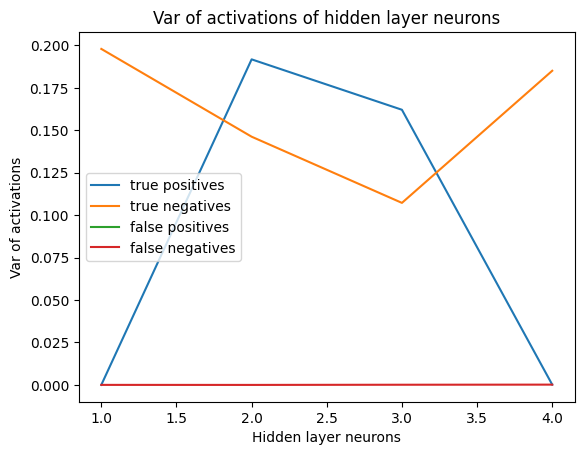

In [41]:
tpa1_v=np.var(true_pos_act_1)
tpa2_v=np.var(true_pos_act_2)
tpa3_v=np.var(true_pos_act_3)
tpa4_v=np.var(true_pos_act_4)
tpvarr=np.array([tpa1_v,tpa2_v,tpa3_v,tpa4_v])

tna1_v=np.var(true_neg_act_1)
tna2_v=np.var(true_neg_act_2)
tna3_v=np.var(true_neg_act_3)
tna4_v=np.var(true_neg_act_4)
tnvarr=np.array([tna1_v,tna2_v,tna3_v,tna4_v])

fpa1_v=np.var(false_pos_act_1)
fpa2_v=np.var(false_pos_act_2)
fpa3_v=np.var(false_pos_act_3)
fpa4_v=np.var(false_pos_act_4)
fpvarr=np.array([fpa1_v,fpa2_v,fpa3_v,fpa4_v])

fna1_v=np.var(false_neg_act_1)
fna2_v=np.var(false_neg_act_2)
fna3_v=np.var(false_neg_act_3)
fna4_v=np.var(false_neg_act_4)
fnvarr=np.array([fna1_v,fna2_v,fna3_v,fna4_v])

import matplotlib.pyplot as plt
x=np.array([1,2,3,4])
plt.plot(x,tpvarr,label='true positives')
plt.plot(x,tnvarr,label='true negatives')
plt.plot(x,fpvarr,label='false positives')
plt.plot(x,fnvarr,label='false negatives')
plt.legend()
plt.title('Var of activations of hidden layer neurons')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Var of activations')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


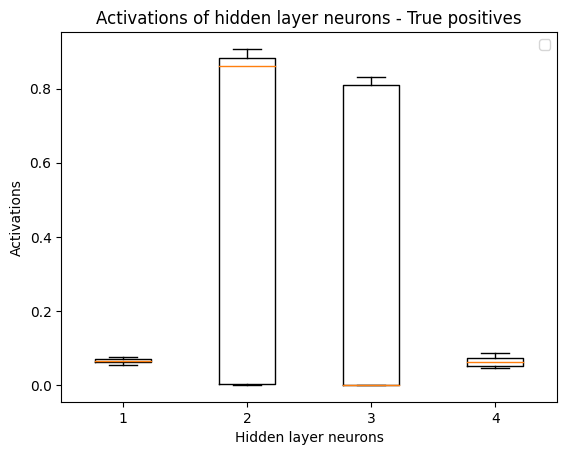

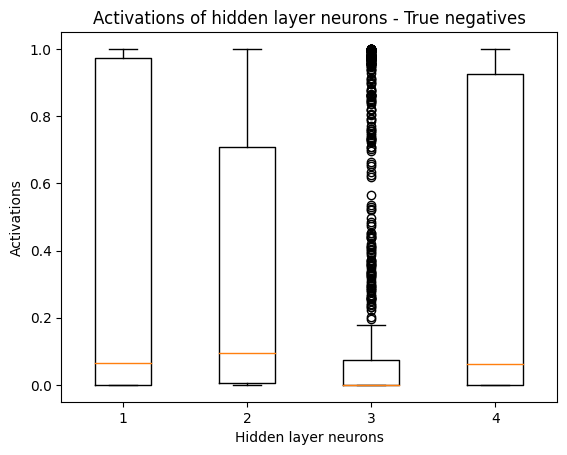

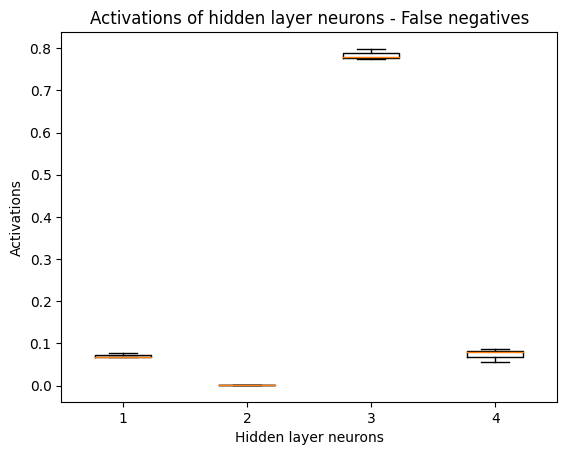

In [42]:
tpdata=[true_pos_act_1,true_pos_act_2,true_pos_act_3,true_pos_act_4]
tndata=[true_neg_act_1,true_neg_act_2,true_neg_act_3,true_neg_act_4]
fpdata=[false_pos_act_1,false_pos_act_2,false_pos_act_3,false_pos_act_4]
fndata=[false_neg_act_1, false_neg_act_2, false_neg_act_3, false_neg_act_4]

plt.boxplot(tpdata)
plt.legend()
plt.title('Activations of hidden layer neurons - True positives')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Activations')
plt.show()

plt.boxplot(tndata)
plt.title('Activations of hidden layer neurons - True negatives')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Activations')
plt.show()

plt.boxplot(fndata)
plt.title('Activations of hidden layer neurons - False negatives')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Activations')
plt.show()